- PostgreSQL에서는 버전 9.6에서 구현된 병렬 쿼리가 여러 개의 백그라운드 작업자 프로세스를 사용하지만 기본적으로 백엔드 프로세스는 연결된 클라이언트에서 실행되는 모든 쿼리를 처리.

**이 백엔드는 5개의 하위 시스템으로 구성.**

- Parser
  - 파서는 일반 텍스트의 SQL 문에서 구문 분석 트리를 생성.
- Analyzer/Analyser
  - 분석기는 구문 분석 트리의 의미 분석을 수행하고 쿼리 트리를 생성.
- Rewriter
  - Rewriter는 규칙이 존재하는 경우 규칙 시스템 에 저장된 규칙을 사용하여 쿼리 트리를 변환 .
- Planner
  - 플래너는 쿼리 트리에서 가장 효과적으로 실행될 수 있는 계획 트리를 생성.
- Executor
  - Executor는 계획 트리에 의해 생성된 순서대로 테이블과 인덱스에 액세스하여 쿼리를 실행.


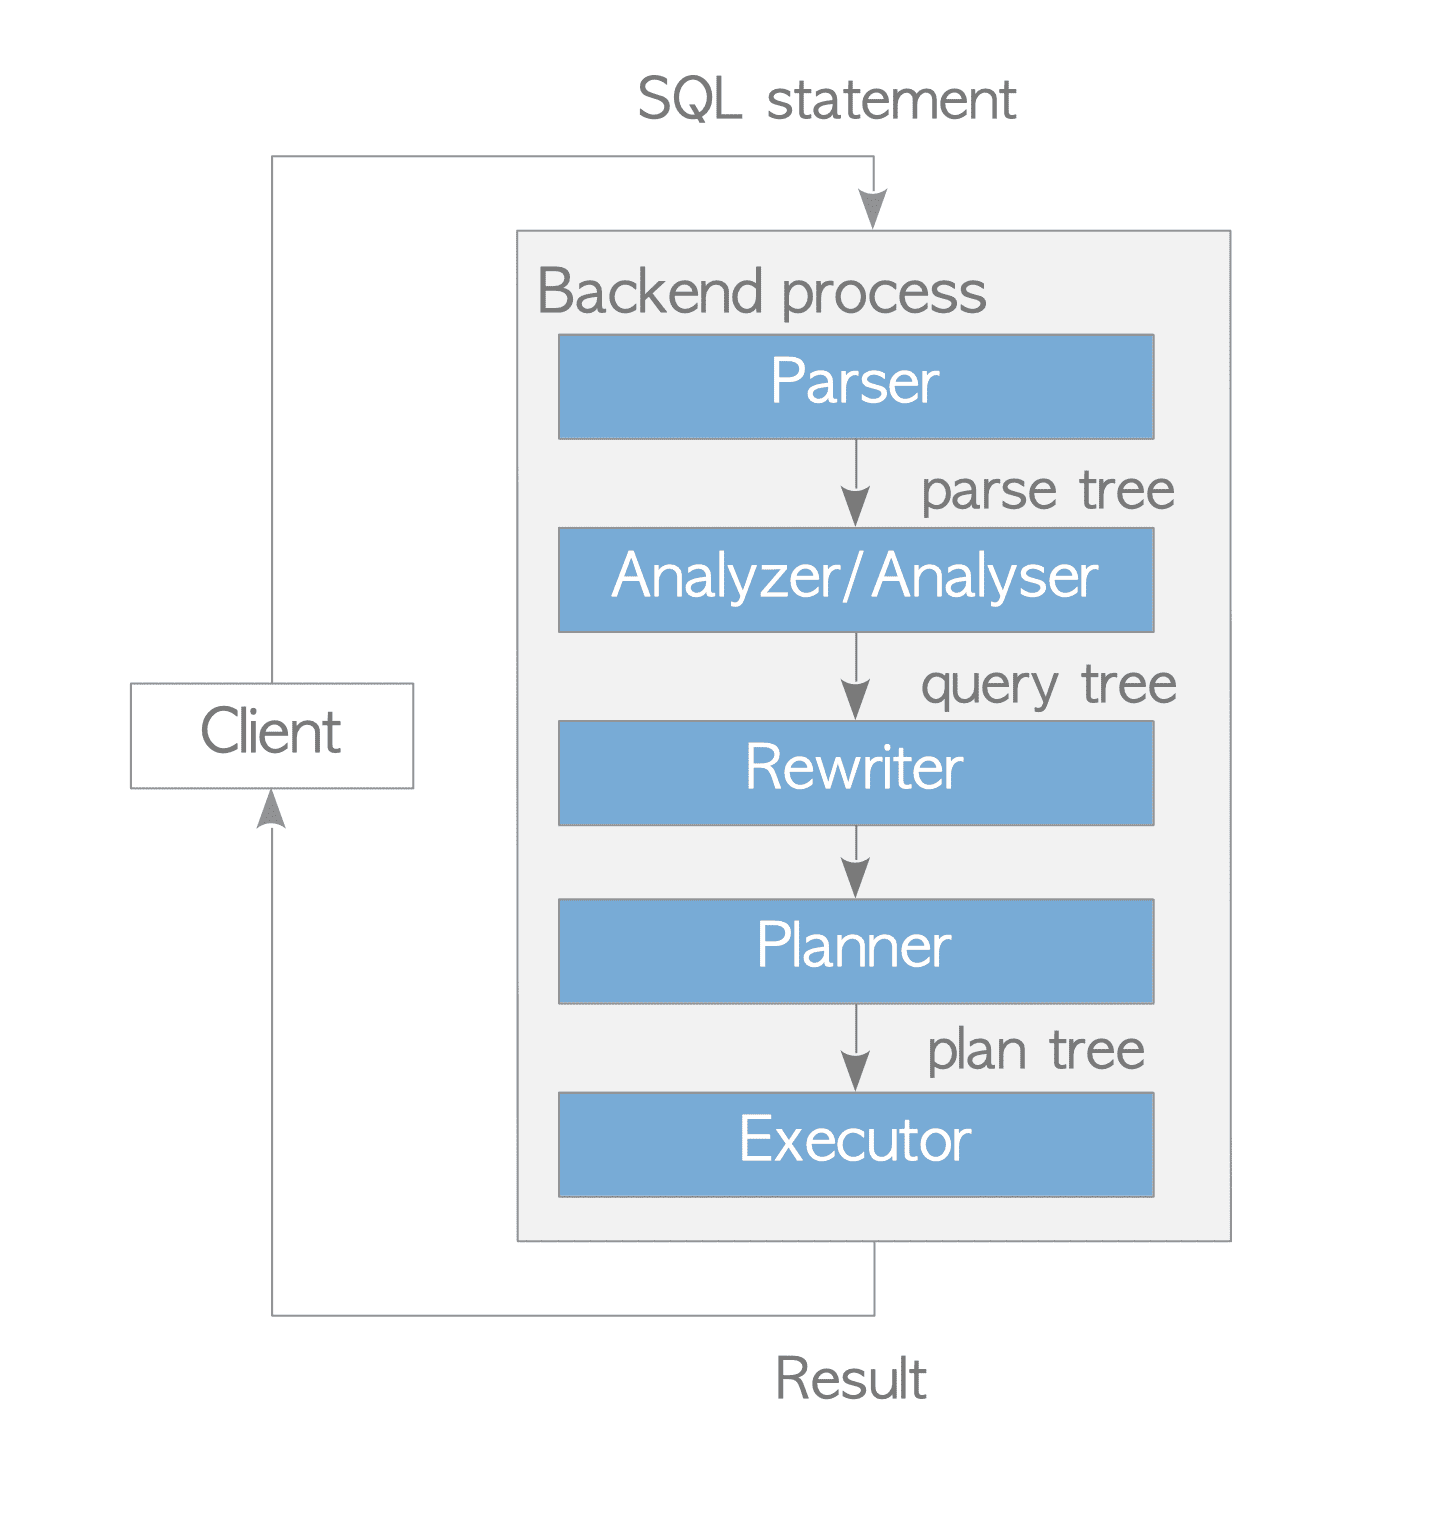

# **Parser**

- 파서는 일반 텍스트의 SQL 문에서 후속 하위 시스템이 읽을 수 있는 구문 분석 트리를 생성




```
testdb=# SELECT id, data FROM tbl_a WHERE id < 300 ORDER BY data;
```

- 구문 분석 트리는 루트 노드가 구문 분석 노드.h 에 정의된 SelectStmt 구조인 트리

**SelectStmt**

```
typedef struct SelectStmt
{
        NodeTag         type;

        /*
         * These fields are used only in "leaf" SelectStmts.
         */
        List       *distinctClause;     /* NULL, list of DISTINCT ON exprs, or
                                         * lcons(NIL,NIL) for all (SELECT DISTINCT) */
        IntoClause *intoClause;         /* target for SELECT INTO */
        List       *targetList;         /* the target list (of ResTarget) */
        List       *fromClause;         /* the FROM clause */
        Node       *whereClause;        /* WHERE qualification */
        List       *groupClause;        /* GROUP BY clauses */
        Node       *havingClause;       /* HAVING conditional-expression */
        List       *windowClause;       /* WINDOW window_name AS (...), ... */

        /*
         * In a "leaf" node representing a VALUES list, the above fields are all
         * null, and instead this field is set.  Note that the elements of the
         * sublists are just expressions, without ResTarget decoration. Also note
         * that a list element can be DEFAULT (represented as a SetToDefault
         * node), regardless of the context of the VALUES list. It's up to parse
         * analysis to reject that where not valid.
         */
        List       *valuesLists;        /* untransformed list of expression lists */

        /*
         * These fields are used in both "leaf" SelectStmts and upper-level
         * SelectStmts.
         */
        List       *sortClause;         /* sort clause (a list of SortBy's) */
        Node       *limitOffset;        /* # of result tuples to skip */
        Node       *limitCount;         /* # of result tuples to return */
        List       *lockingClause;      /* FOR UPDATE (list of LockingClause's) */
        WithClause *withClause;         /* WITH clause */

        /*
         * These fields are used only in upper-level SelectStmts.
         */
        SetOperation op;                /* type of set op */
        bool            all;            /* ALL specified? */
        struct SelectStmt *larg;        /* left child */
        struct SelectStmt *rarg;        /* right child */
        /* Eventually add fields for CORRESPONDING spec here */
} SelectStmt;
```

**파싱트리**

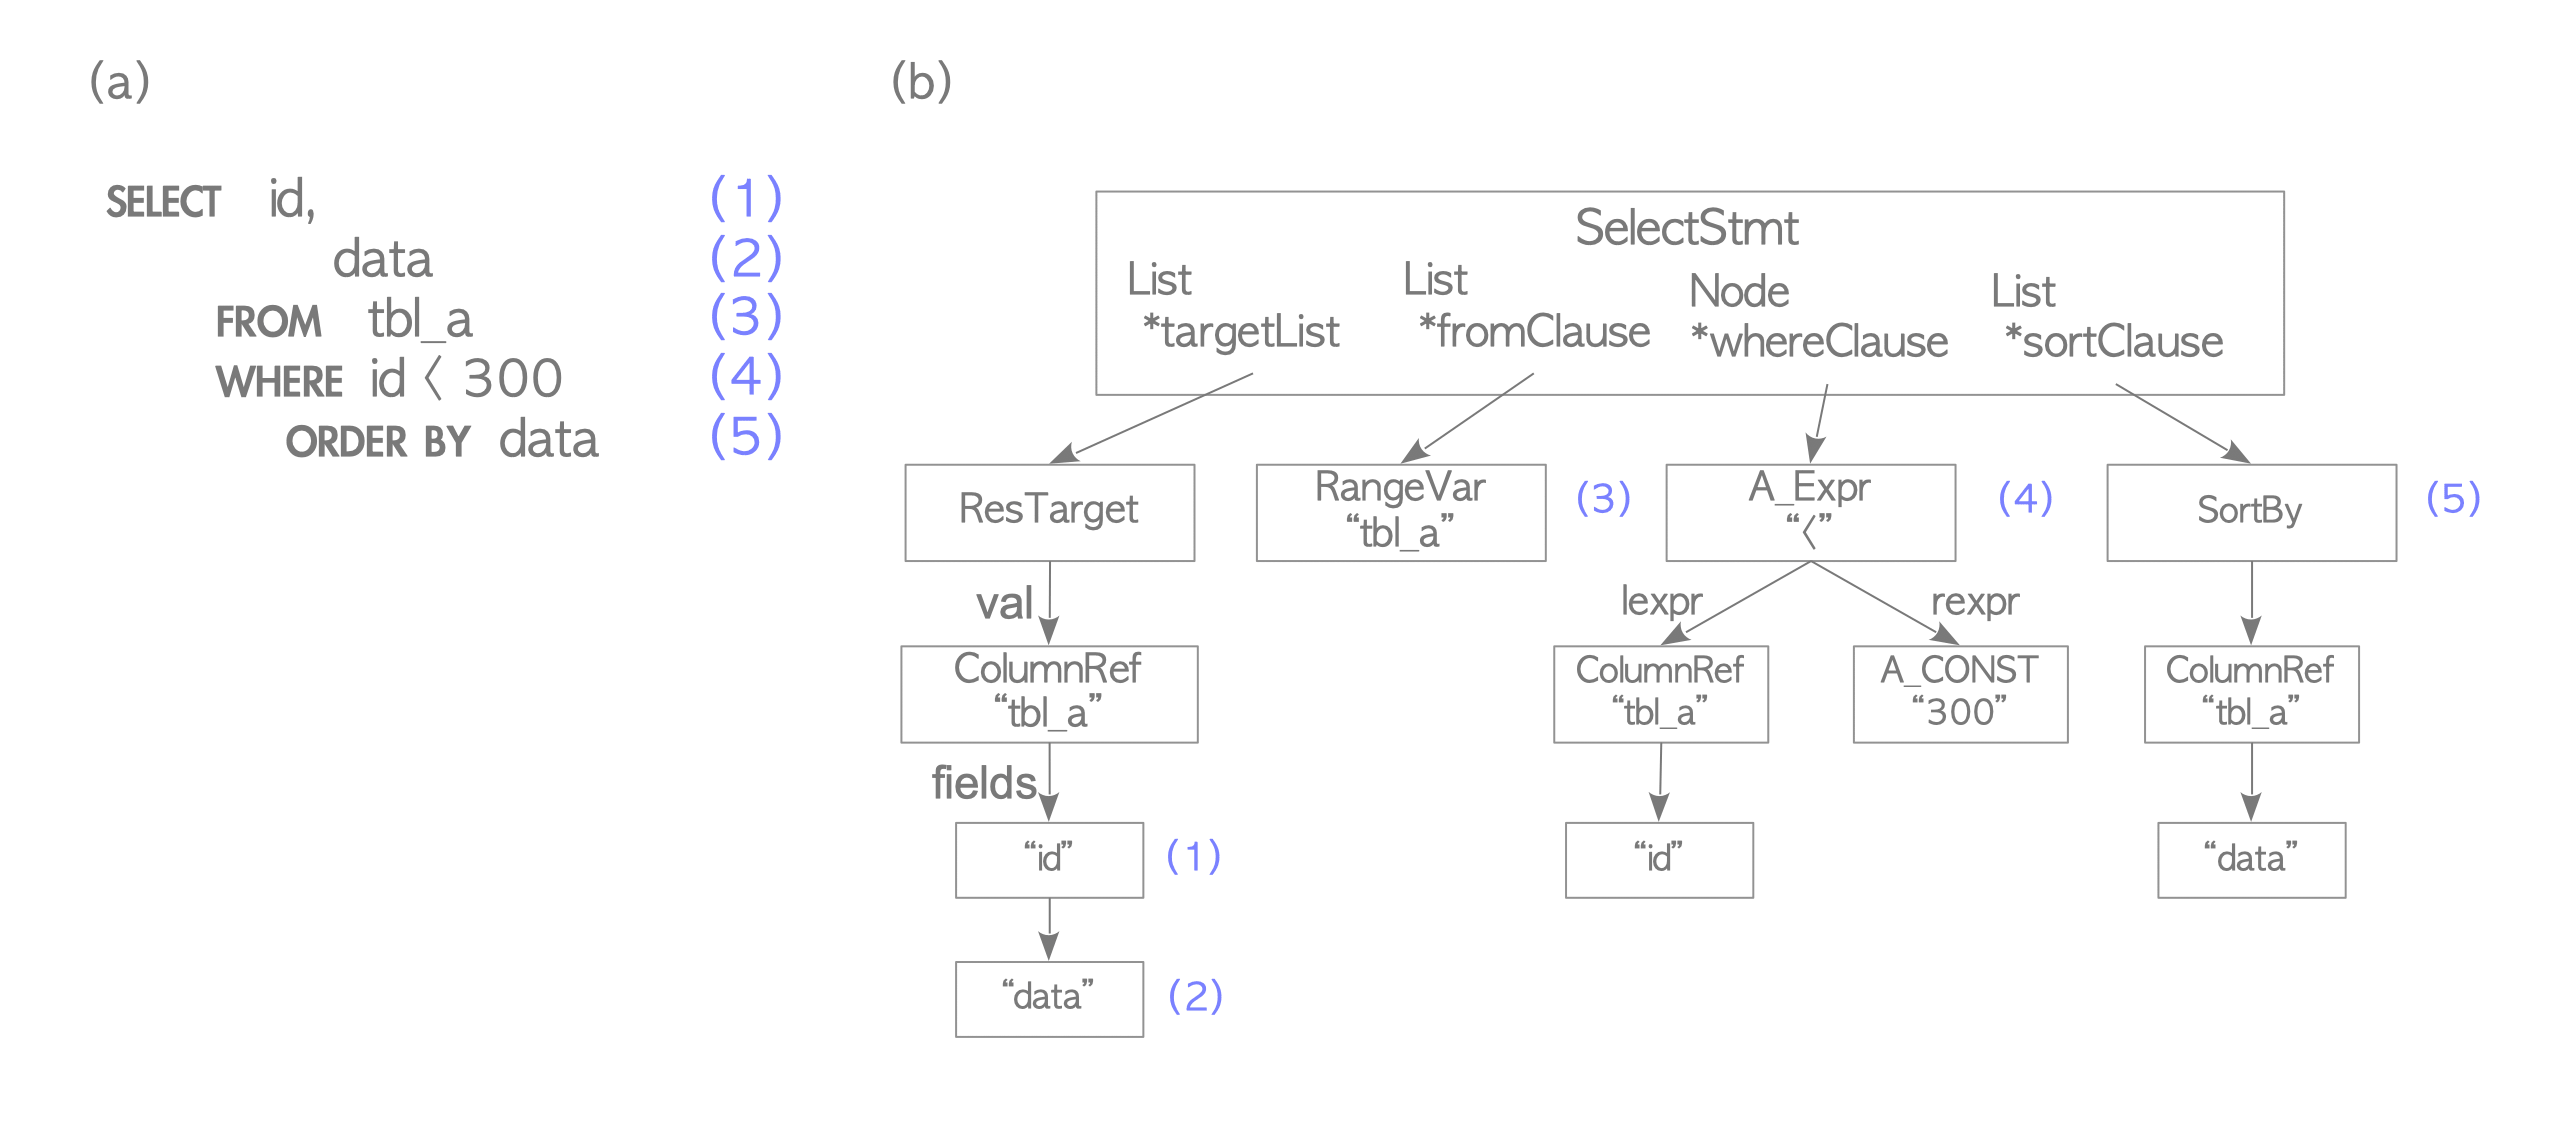

- SELECT 쿼리의 요소와 구문 분석 트리의 해당 요소에는 동일한 번호가 지정.
  - 예를 들어 (1)은 첫 번째 대상 목록의 항목이고 테이블의 'id' 열.
  - (4)는 WHERE 절. 등등.

- 파서는 구문 분석 트리를 생성할 때 입력 구문만 확인.
  - 따라서 쿼리에 구문 오류가 있는 경우에만 오류를 반환.

- 파서는 입력 쿼리의 의미를 확인하지 않음.
  - 예를 들어 쿼리에 존재하지 않는 테이블 이름이 포함되어 있어도 파서는 오류를 반환하지 않음.
  - 의미론적 검사는 분석기/분석기에 의해 수행.

# **Analyzer/Analyser**

- 분석기는 파서가 생성한 구문 분석 트리의 의미 분석을 실행하고 쿼리 트리를 생성.

- 쿼리 트리의 루트는 parsenodes.h 에 정의된 쿼리 구조 .
  - 이 구조에는 명령 유형(SELECT, INSERT 등)과 같은 해당 쿼리의 메타데이터와 여러 리프가 포함.
  - 각 리프는 목록이나 트리를 형성하고 개별 특정 절에 대한 데이터를 보유.


**Query**


```
/*
 * Query -
 *	  Parse analysis turns all statements into a Query tree
 *	  for further processing by the rewriter and planner.
 *
 *	  Utility statements (i.e. non-optimizable statements) have the
 *	  utilityStmt field set, and the Query itself is mostly dummy.
 *	  DECLARE CURSOR is a special case: it is represented like a SELECT,
 *	  but the original DeclareCursorStmt is stored in utilityStmt.
 *
 *	  Planning converts a Query tree into a Plan tree headed by a PlannedStmt
 *	  node --- the Query structure is not used by the executor.
 */
typedef struct Query
{
	NodeTag		type;

	CmdType		commandType;	/* select|insert|update|delete|merge|utility */

	/* where did I come from? */
	QuerySource querySource pg_node_attr(query_jumble_ignore);

	/*
	 * query identifier (can be set by plugins); ignored for equal, as it
	 * might not be set; also not stored.  This is the result of the query
	 * jumble, hence ignored.
	 */
	uint64		queryId pg_node_attr(equal_ignore, query_jumble_ignore, read_write_ignore, read_as(0));

	/* do I set the command result tag? */
	bool		canSetTag pg_node_attr(query_jumble_ignore);

	Node	   *utilityStmt;	/* non-null if commandType == CMD_UTILITY */

	/*
	 * rtable index of target relation for INSERT/UPDATE/DELETE/MERGE; 0 for
	 * SELECT.  This is ignored in the query jumble as unrelated to the
	 * compilation of the query ID.
	 */
	int			resultRelation pg_node_attr(query_jumble_ignore);

	/* has aggregates in tlist or havingQual */
	bool		hasAggs pg_node_attr(query_jumble_ignore);
	/* has window functions in tlist */
	bool		hasWindowFuncs pg_node_attr(query_jumble_ignore);
	/* has set-returning functions in tlist */
	bool		hasTargetSRFs pg_node_attr(query_jumble_ignore);
	/* has subquery SubLink */
	bool		hasSubLinks pg_node_attr(query_jumble_ignore);
	/* distinctClause is from DISTINCT ON */
	bool		hasDistinctOn pg_node_attr(query_jumble_ignore);
	/* WITH RECURSIVE was specified */
	bool		hasRecursive pg_node_attr(query_jumble_ignore);
	/* has INSERT/UPDATE/DELETE in WITH */
	bool		hasModifyingCTE pg_node_attr(query_jumble_ignore);
	/* FOR [KEY] UPDATE/SHARE was specified */
	bool		hasForUpdate pg_node_attr(query_jumble_ignore);
	/* rewriter has applied some RLS policy */
	bool		hasRowSecurity pg_node_attr(query_jumble_ignore);
	/* is a RETURN statement */
	bool		isReturn pg_node_attr(query_jumble_ignore);

	List	   *cteList;		/* WITH list (of CommonTableExpr's) */

	List	   *rtable;			/* list of range table entries */

	/*
	 * list of RTEPermissionInfo nodes for the rtable entries having
	 * perminfoindex > 0
	 */
	List	   *rteperminfos pg_node_attr(query_jumble_ignore);
	FromExpr   *jointree;		/* table join tree (FROM and WHERE clauses);
								 * also USING clause for MERGE */

	List	   *mergeActionList;	/* list of actions for MERGE (only) */
	/* whether to use outer join */
	bool		mergeUseOuterJoin pg_node_attr(query_jumble_ignore);

	List	   *targetList;		/* target list (of TargetEntry) */

	/* OVERRIDING clause */
	OverridingKind override pg_node_attr(query_jumble_ignore);

	OnConflictExpr *onConflict; /* ON CONFLICT DO [NOTHING | UPDATE] */

	List	   *returningList;	/* return-values list (of TargetEntry) */

	List	   *groupClause;	/* a list of SortGroupClause's */
	bool		groupDistinct;	/* is the group by clause distinct? */

	List	   *groupingSets;	/* a list of GroupingSet's if present */

	Node	   *havingQual;		/* qualifications applied to groups */

	List	   *windowClause;	/* a list of WindowClause's */

	List	   *distinctClause; /* a list of SortGroupClause's */

	List	   *sortClause;		/* a list of SortGroupClause's */

	Node	   *limitOffset;	/* # of result tuples to skip (int8 expr) */
	Node	   *limitCount;		/* # of result tuples to return (int8 expr) */
	LimitOption limitOption;	/* limit type */

	List	   *rowMarks;		/* a list of RowMarkClause's */

	Node	   *setOperations;	/* set-operation tree if this is top level of
								 * a UNION/INTERSECT/EXCEPT query */

	/*
	 * A list of pg_constraint OIDs that the query depends on to be
	 * semantically valid
	 */
	List	   *constraintDeps pg_node_attr(query_jumble_ignore);

	/* a list of WithCheckOption's (added during rewrite) */
	List	   *withCheckOptions pg_node_attr(query_jumble_ignore);

	/*
	 * The following two fields identify the portion of the source text string
	 * containing this query.  They are typically only populated in top-level
	 * Queries, not in sub-queries.  When not set, they might both be zero, or
	 * both be -1 meaning "unknown".
	 */
	/* start location, or -1 if unknown */
	int			stmt_location;
	/* length in bytes; 0 means "rest of string" */
	int			stmt_len pg_node_attr(query_jumble_ignore);
} Query;
```


**쿼리 트리**

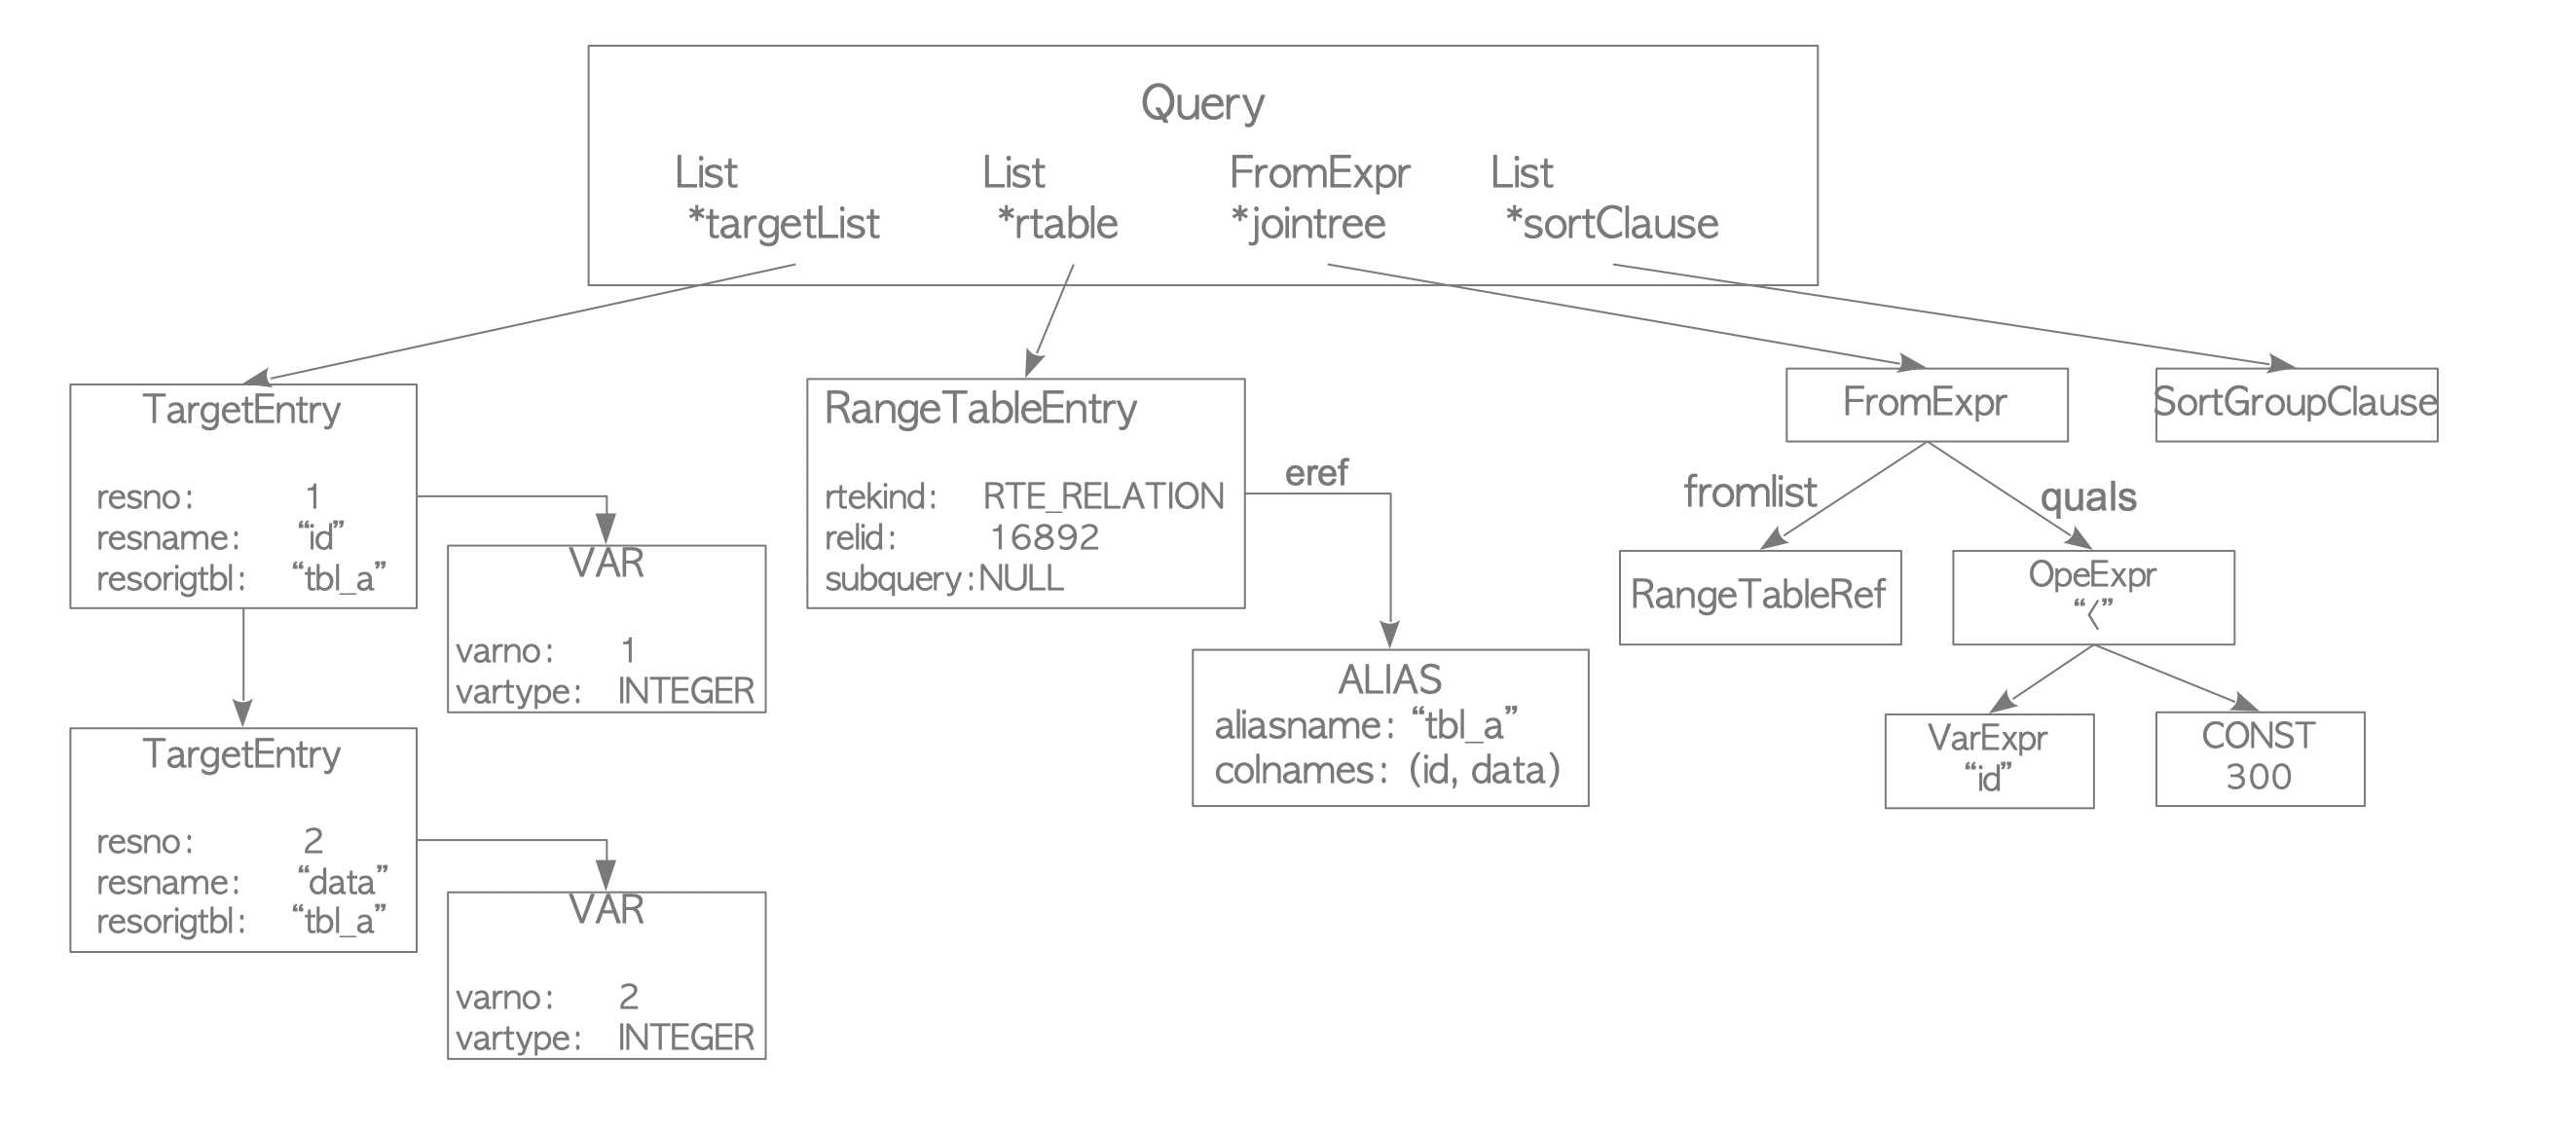

**쿼리 트리 설명**

- targetlist는 이 쿼리의 결과인 열 목록.
  - 이 예에서 목록은 'id'와 'data'라는 두 개의 열로 구성. 입력 쿼리 트리가 '*'(별표)를 사용하면 분석기/분석기가 이를 모든 열로 명시적으로 대체.

- 범위 테이블은 이 쿼리에 사용되는 관계 목록.
  - 이 예에서 목록에는 테이블의 OID , 테이블 이름 등 'tbl_a' 테이블의 정보가 포함.

- 조인 트리는 FROM 절과 WHERE 절을 저장.

- 정렬 절은 SortGroupClause의 목록.


# **Rewriter**

- 리라이터는 룰 시스템을 구현하는 시스템
  - 필요한 경우 pg_rules 시스템 카탈로그 에 저장된 규칙에 따라 쿼리 트리를 변환
  - 규칙 시스템


- PostgreSQL의 보기는 규칙 시스템을 사용하여 구현.
 - CREATE VIEW 명령 으로 뷰를 정의하면 해당 규칙이 자동으로 생성되어 카탈로그에 저장.

- 다음 뷰가 이미 정의되어 있고 해당 규칙이 pg_rules 시스템 카탈로그에 저장되어 있다고 가정.



```
sampledb=# CREATE VIEW employees_list
sampledb-#      AS SELECT e.id, e.name, d.name AS department
sampledb-#            FROM employees AS e, departments AS d WHERE e.department_id = d.id;
```

- 아래에 표시된 뷰를 포함하는 쿼리가 실행되면 파서는 그림 같이 구문 분석 트리를 생성.

```
sampledb=# SELECT * FROM employees_list;
```

- 이 단계에서 Rewriter는 범위 테이블 노드를 pg_rules 에 저장된 해당 뷰인 하위 쿼리의 구문 분석 트리로 처리.



**리라이터 단계의 예**

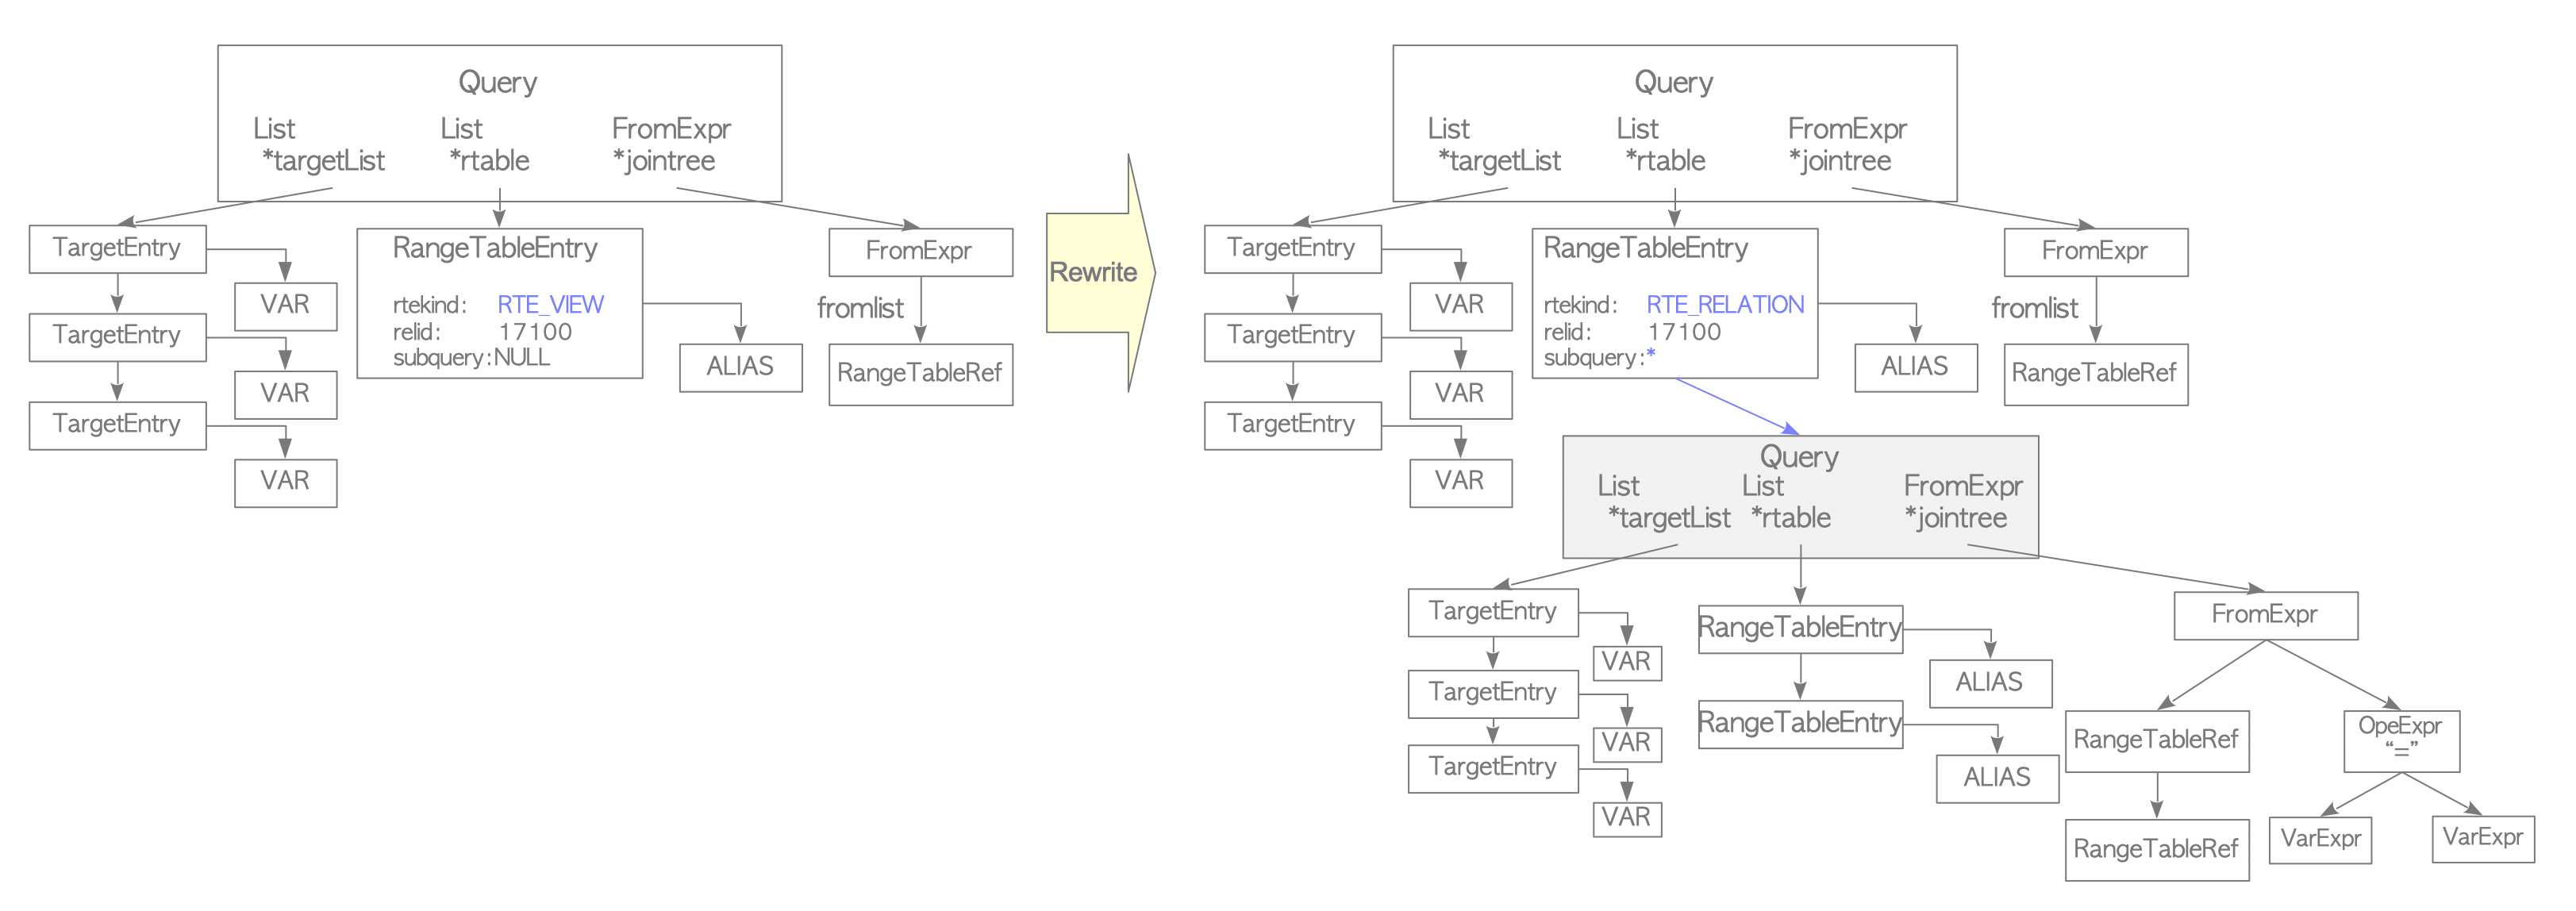


- PostgreSQL은 이러한 메커니즘을 사용하여 뷰를 실현하므로 버전 9.2까지는 뷰를 업데이트할 수 없음.
  - 그러나 버전 9.3부터 보기를 업데이트할 수 있음.
  - 그럼에도 불구하고 뷰를 업데이트하는 데는 많은 제한 사항이 있음.

# **Planner and Executor**

- Planner는 Rewriter로부터 쿼리 트리를 수신하고 Executor에서 가장 효과적으로 처리할 수 있는 (쿼리) 계획 트리를 생성.

- PostgreSQL의 플래너는 순수한 비용 기반 최적화를 기반으로 함.
- 규칙 기반 최적화나 힌트를 지원하지 않습니다. 이 플래너는 PostgreSQL에서 가장 복잡한 하위 시스템.

**pg_hint_plan**

- PostgreSQL은 SQL에서 플래너 힌트를 지원하지 않으며 영원히 지원되지도 않음.
- 쿼리에 힌트를 사용하려면 pg_hint_plan 에 참조된 확장을 고려해 볼 가치가 있음

- 다른 RDBMS와 마찬가지로 PostgreSQL의 EXPLAIN 명령은 계획 트리 자체를 표시


```
testdb=# EXPLAIN SELECT * FROM tbl_a WHERE id < 300 ORDER BY data;
                          QUERY PLAN
---------------------------------------------------------------
 Sort  (cost=182.34..183.09 rows=300 width=8)
   Sort Key: data
   ->  Seq Scan on tbl_a  (cost=0.00..170.00 rows=300 width=8)
         Filter: (id < 300)
(4 rows)
```

- 표시된 계획 트리를 보여 줌

**간단한 계획 트리와 계획 트리와 EXPLAIN 명령 결과 간의 관계**

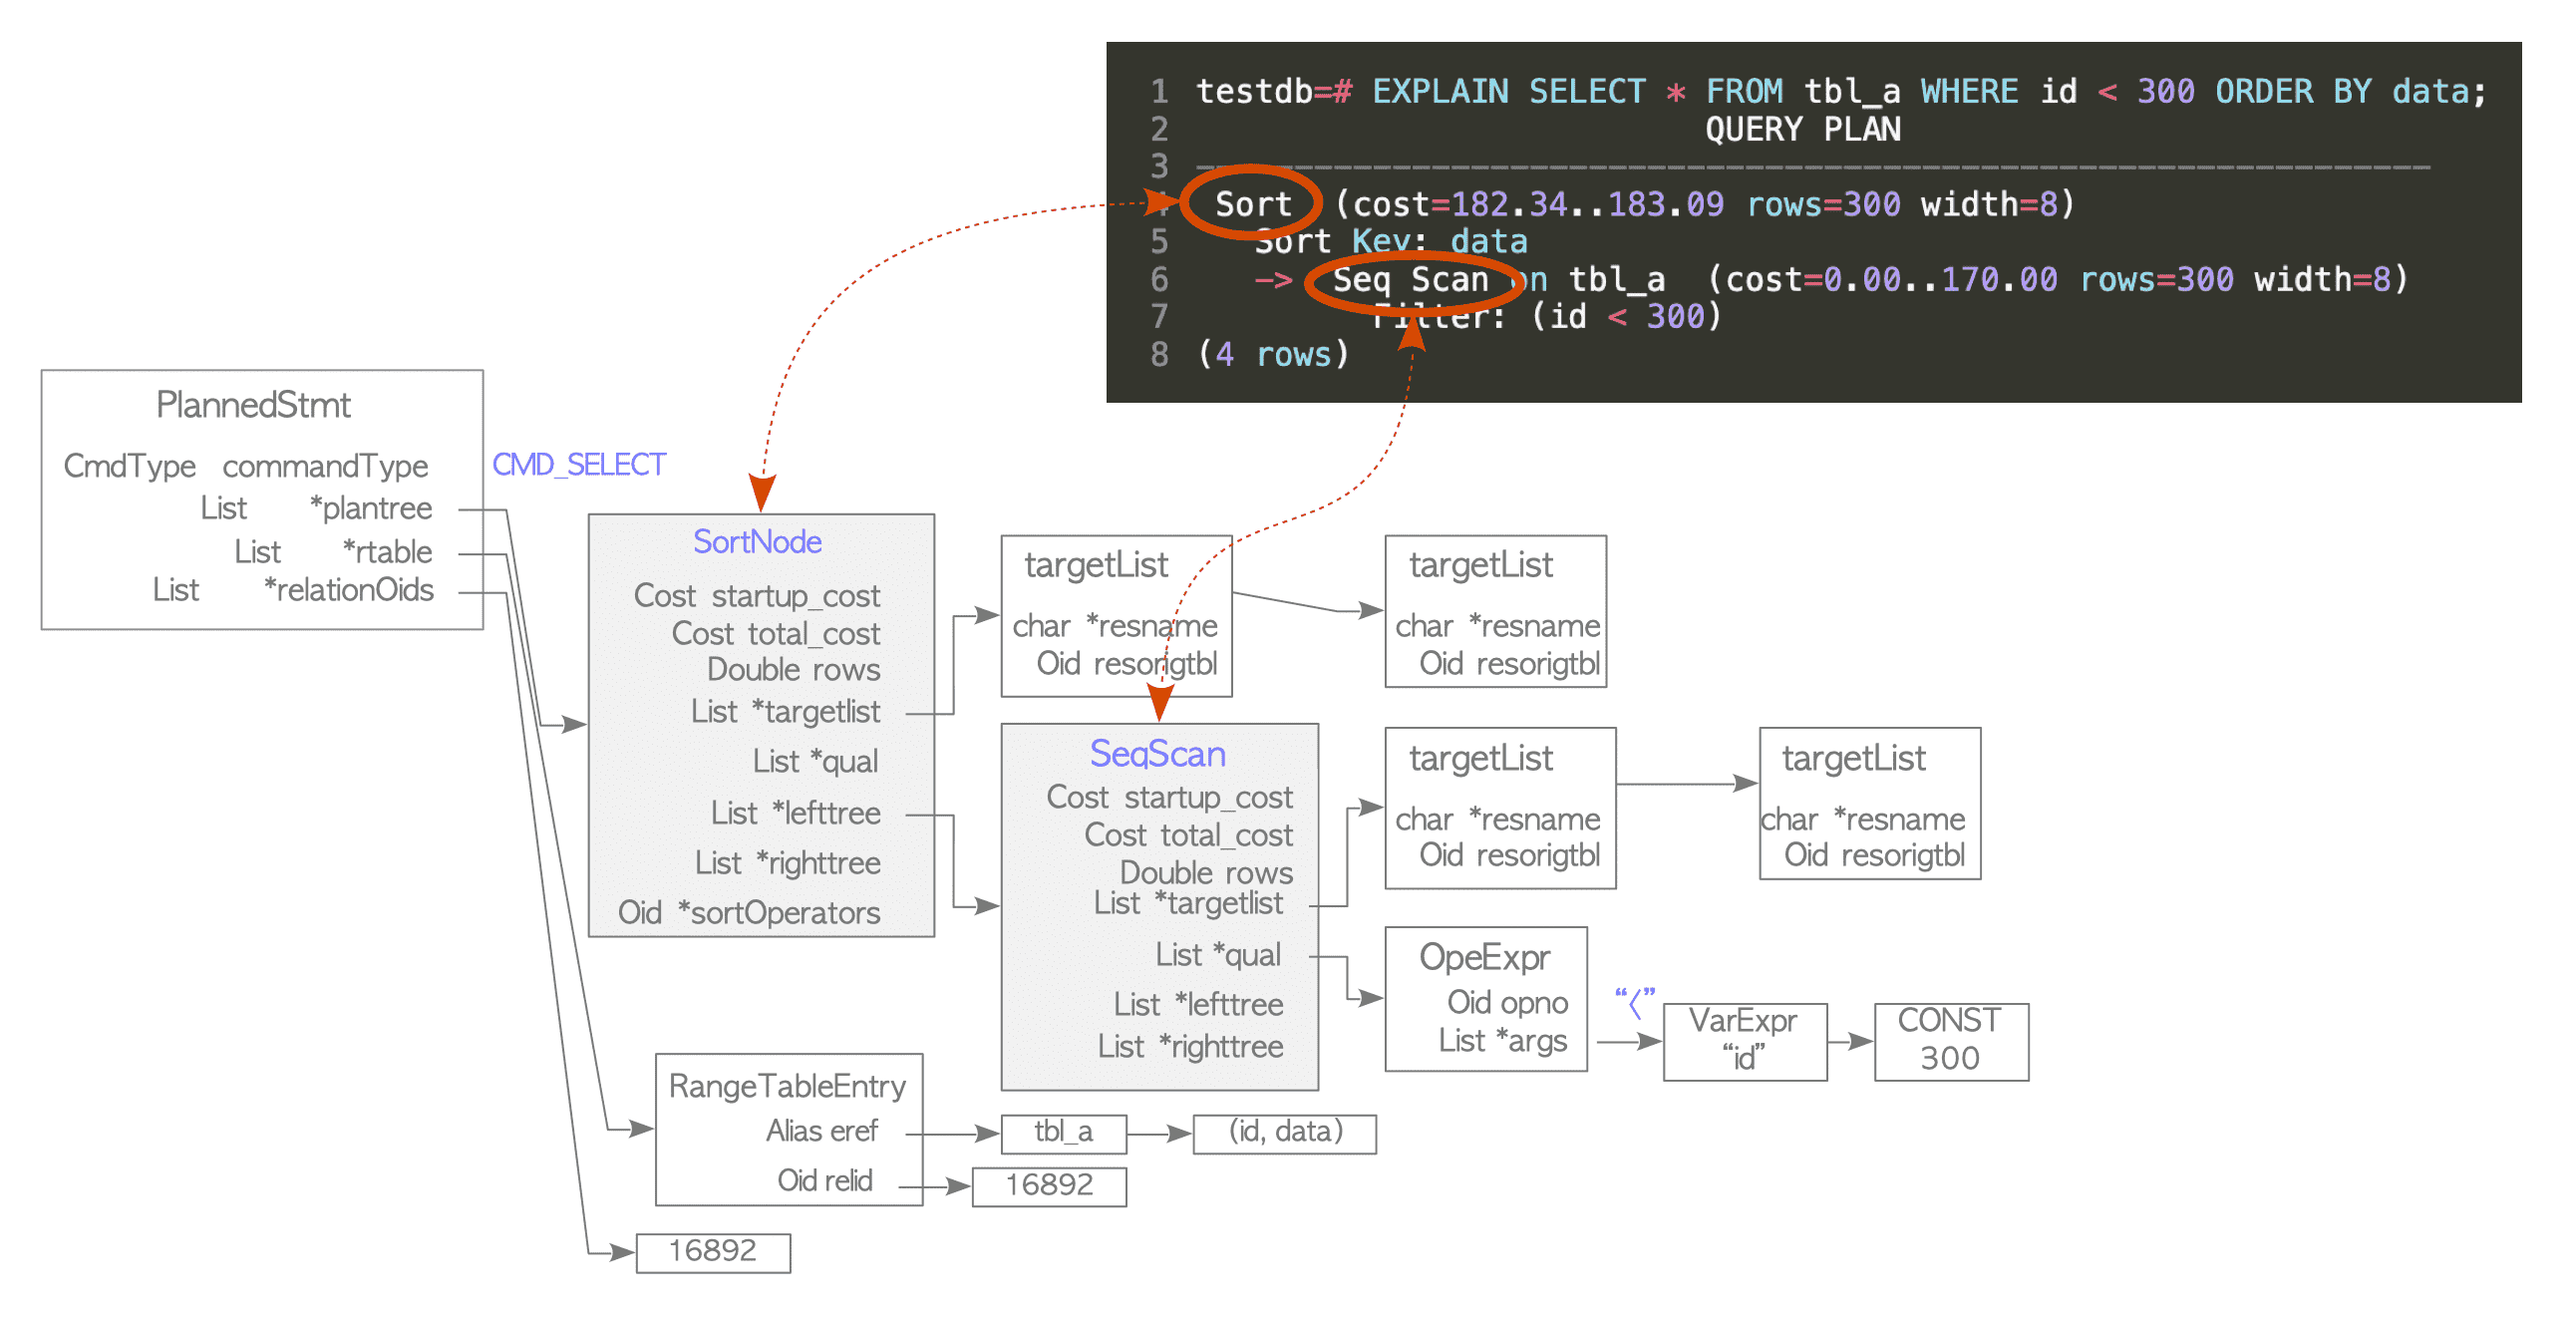


- 계획 트리는 계획 노드 라는 요소로 구성되며 PlannedStmt 구조 의 식물 트리 목록과 연결.
  - 이러한 요소는 plannodes.h 에 정의되어 있음

- 각 계획 노드에는 실행자가 처리하는 데 필요한 정보가 있음.
  - 단일 테이블 쿼리의 경우 실행기는 계획 트리 끝부터 루트까지 처리.

- 예를 들어, 그림의 계획 트리는 정렬 노드와 순차 스캔 노드의 목록.
  - 따라서 Executor는 테이블 tbl_a를 순차적 스캔으로 스캔한 후, 얻은 결과를 정렬.

- 실행기는 버퍼 관리자를 통해 데이터베이스 클러스터의 테이블과 인덱스를 읽고 씀.
-  Executor는 쿼리를 처리할 때 미리 할당된 temp_buffers, work_mem 등 일부 메모리 영역을 사용하고, 필요한 경우 임시 파일을 생성.

- 튜플에 액세스할 때 PostgreSQL은 동시성 제어 메커니즘을 사용하여 실행 중인 트랜잭션의 일관성과 격리를 유지



**실행기, 버퍼 관리자 및 임시 파일 간의 관계.**

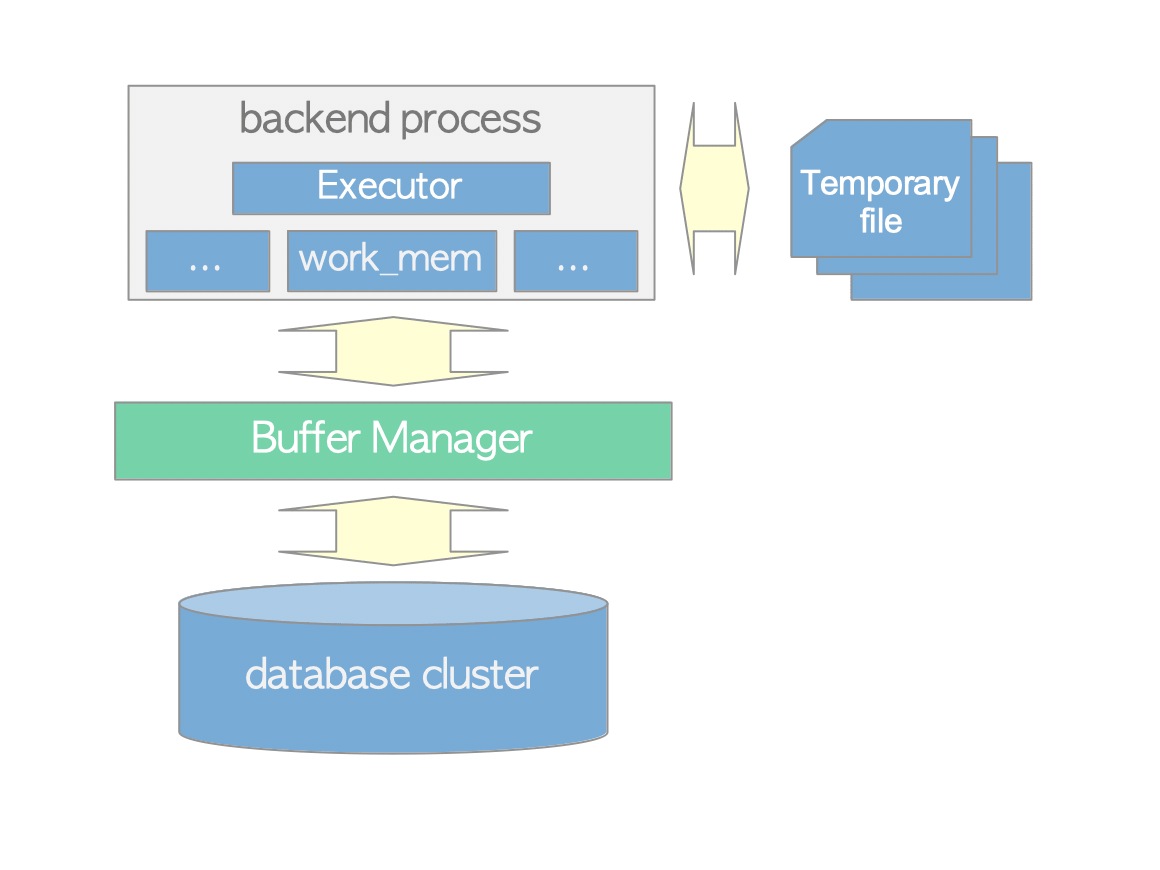